In [1]:
import os
import pickle
import models

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
from numpyro.diagnostics import hpdi

from hbmep.nn import functional as F
from hbmep.model.utils import Site as site

from hbmep.config import Config
from hbmep.model.utils import Site as site
from scipy import stats

from models import NonHierarchicalBayesianModel

USER = os.environ["USER"]

MAX_THRESHOLD_CONST = 2.13 #CONSTANT WILL BE MAX STIM INTENSITY / highest rat threshold
NUM_THRESHOLD_POINTS = 500

# NORMALIZATION WILL BE ACROSS ELECTRODE

In [2]:
src = f"/home/{USER}/repos/rat-mapping-paper/reports/non-hierarchical/L_SHIE/non_hierarchical_bayesian_model/inference.pkl"
with open(src, "rb") as f:
    (
        df,
        encoder_dict,
        model,
        posterior_samples,
    ) = pickle.load(f)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [5]:
posterior_samples[site.a].shape

(4000, 8, 4, 2, 6)

In [6]:
posterior_samples[site.a].mean(axis=(0,2,3,4))

array([ 72.2835291 , 129.9644484 ,  77.01604939, 313.1112451 ,
        78.97553433, 352.45196006, 187.66975035,  43.89419249])

In [26]:
df.columns

Index(['pulse_amplitude', 'pulse_train_frequency', 'pulse_period',
       'pulse_duration', 'pulse_count', 'train_delay', 'channel1_1',
       'channel1_2', 'channel1_3', 'channel1_4', 'channel2_1', 'channel2_2',
       'channel2_3', 'channel2_4', 'charge_params_1', 'charge_params_2',
       'charge_params_3', 'charge_params_4', 'bank_check', 'run', 'enabled',
       'channel_failA', 'channel_failB', 'channel_fail_comb', 'time_pulse',
       'time', 'ix_onsets', 'LBiceps', 'LFCR', 'LECR', 'LTriceps', 'LADM',
       'LDeltoid', 'LBicepsFemoris', 'RBiceps', 'channel1_laterality',
       'channel1_segment', 'channel1_designation', 'channel2_laterality',
       'channel2_segment', 'channel2_designation', 'compound_position',
       'compound_charge_params', 'participant', 'subdir_pattern',
       'charge_param_error'],
      dtype='object')

In [16]:
df['compound_position'].unique()

array([3, 1, 2, 0])

In [21]:
subjects = sorted(df['participant'].unique())
positions = sorted(df['compound_position'].unique())
charges = sorted(df["compound_charge_params"].unique())
muscles = model.response

In [37]:
temp = df

In [39]:
temp['LBiceps']

0       0.021462
1       0.019248
2       0.063940
3       0.021290
4       0.013735
          ...   
3567    3.220218
3568    1.676773
3569    4.633438
3570    2.705372
3571    3.916778
Name: LBiceps, Length: 3572, dtype: float64

In [42]:
df[muscles[0]]

0       0.014164
1       0.013828
2       0.013715
3       0.013984
4       0.012980
          ...   
3567    0.110528
3568    0.079315
3569    1.667915
3570    0.087336
3571    0.189760
Name: LADM, Length: 3572, dtype: float64

In [49]:
stim_max = []
for subject in subjects:
    for position in positions:
        for charge in charges:
            for muscle in muscles:
                temp = df[
                    (df.participant == subject)
                    & (df.compound_position == position)
                    & (df.compound_charge_params == charge)
                    ]
                temp = temp.loc[:,[muscle, 'pulse_amplitude']]
                temp = temp.pulse_amplitude.max()
                stim_max.append(temp)
stim_max = np.array(stim_max)
stim_max = stim_max.reshape(len(subjects), len(positions), len(charges), len(muscles))

In [50]:
stim_max.shape

(8, 4, 2, 6)

In [54]:
granular_mean = posterior_samples[site.a].mean(0)

In [64]:
(stim_max / granular_mean).mean(axis = (1,2,3)).min()

2.489458686888722

In [50]:
charges = sorted(df["compound_charge_params"].unique())     # Sort the encoded charges so they are in the same order as the posterior samples
charges = encoder_dict['compound_charge_params'].inverse_transform(charges)     # Then decode the charges, this maintains the order of the charges
charges


array(['20-0-80-25', '50-0-50-100'], dtype=object)

In [52]:
named_params = [site.a, site.b, site.L, site.ell, site.H]
params = [posterior_samples[param][ ...] for param in named_params]

for named_param, param in zip(named_params, params):
    print(named_param, param.shape)


a (4000, 8, 4, 2, 6)
b (4000, 8, 4, 2, 6)
L (4000, 8, 4, 2, 6)
ℓ (4000, 8, 4, 2, 6)
H (4000, 8, 4, 2, 6)


In [53]:
subjects = sorted(df['participant'].unique())
subjects = encoder_dict['participant'].inverse_transform(subjects)
subjects


array(['amap01', 'amap02', 'amap03', 'amap04', 'amap05', 'amap06',
       'amap07', 'amap08'], dtype=object)

In [54]:
positions = sorted(df['compound_position'].unique())
positions = encoder_dict['compound_position'].inverse_transform(positions)
positions


array(['-C6LC', 'C6LC-', 'C6LC-C6LX', 'C6LX-C6LC'], dtype=object)

In [55]:
def get_normalized_input_output(charge_ind):
    # charge_ind = 0
    norm_y = []
    norm_x = []

    for subject_ind, subject in enumerate(subjects):
        # Fix the subject index and charge index
        curr_params = [
            params[:, subject_ind, :, charge_ind, :, None] for params in params
        ]

        # Take nanmean across posterior samples
        temp = np.nanmean(curr_params[0], axis=0)
        # Take nanmedian across compound positions and muscles
        median_threshold = np.nanmedian(temp)

        x_temp = np.linspace(0.,  median_threshold * MAX_THRESHOLD_CONST, NUM_THRESHOLD_POINTS)
        x_temp = x_temp[None, None, None, :]

        temp_thresh = F.rectified_logistic(
            x_temp,
            *curr_params
        )
        # Remove offset
        temp_thresh = temp_thresh - curr_params[2]
        norm_y.append(temp_thresh)
        norm_x.append(x_temp)

    norm_x = np.array(norm_x)
    norm_y = np.array(norm_y)
    norm_y = ma.masked_invalid(norm_y)
    return norm_x, norm_y


In [56]:
charge_ind = 0
x, y = get_normalized_input_output(charge_ind=charge_ind)
print(x.shape, y.shape)


(8, 1, 1, 1, 500) (8, 4000, 4, 6, 500)


In [57]:
# Take the maximum curve value across positions and intensity values
num_masked = y.mask.any(axis=(2, -1)).sum()
y_max = ma.max(y, axis=(2, -1), keepdims=True)
assert num_masked == y_max.mask.sum()


In [58]:
# Normalize using the maximum value
num_masked = y.mask.sum()
y = ma.where(y_max, y / y_max, 0.)
assert num_masked == y.mask.sum()


In [59]:
p = ma.sum(y, axis=-2, keepdims=True)

num_masked = y.mask.sum()
p = ma.where(p, y / p, 1 / y.shape[-2])
assert num_masked == p.mask.sum()


In [60]:
num_masked = p.mask.sum()
plogp = ma.where(p, p * ma.log(p), 0.)
assert num_masked == plogp.mask.sum()



In [61]:
entropy = 1 + (plogp.sum(axis=-2) / np.log(y.shape[-2]))
entropy.shape


(8, 4000, 4, 500)

In [62]:
auc = np.trapz(y=entropy[...,:20], x=np.linspace(0, MAX_THRESHOLD_CONST, NUM_THRESHOLD_POINTS)[:20], axis=-1)
auc.shape


(8, 4000, 4)

In [63]:
auc = auc.mean(axis=1)
auc.shape


(8, 4)

In [64]:
mat = auc[:, :, None] - auc[:, None, :]
mat.shape


(8, 4, 4)

In [65]:
test = stats.ttest_1samp(mat, popmean=0, axis=0)
pvalues = test.pvalue
pvalues.shape


(4, 4)

In [66]:
# verify order in heatmap
(auc[:, 0] - auc[:, 3]).mean()

0.001786092443717592

<Axes: >

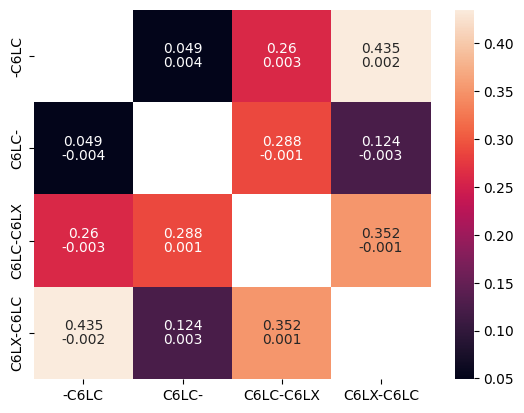

In [67]:
sns.heatmap(pvalues, xticklabels=positions, yticklabels=positions, annot=False)
sns.heatmap(pvalues, xticklabels=positions, yticklabels=positions, annot=np.round(mat.mean(axis=0).data, 3), annot_kws={'va':'top'}, fmt="", cbar=False)
sns.heatmap(pvalues, xticklabels=positions, yticklabels=positions, annot=np.round(pvalues, 3), annot_kws={'va':'bottom'}, fmt="", cbar=False)


In [68]:
# src = f"/home/andres/repos/rat-mapping-paper/notebooks/L_SHIE/selectivity_means.pkl"

# with open(src, "wb") as f:
#     pickle.dump([dashc , cdash, c_x, x_c], f)